## Synthetic Data Generation

### Why Use Synthetic Evaluation Data?

Evaluating RAG (Retrieval-Augmented Generation) augmented pipelines is crucial for assessing their performance. However, manually creating hundreds of QA (Question-Context-Answer) samples from documents can be time-consuming and labor-intensive. Additionally, human-generated questions may struggle to reach the level of complexity required for a thorough evaluation, ultimately impacting the quality of the assessment.
By using synthetic data generation **developer time in data aggregation process can be reduced by 90%.**

### How Does RAGAS Differ in Evaluation Data Generation?

RAGAS takes a novel approach to evaluation data generation. An ideal evaluation dataset should encompass various types of questions encountered in production, including questions of varying difficulty levels. LLMs by default are not good at creating diverse samples as it tends to follow common paths. Inspired by works like [Evol-Instruct](https://arxiv.org/abs/2304.12244), RAGAS achieves this by employing an evolutionary generation paradigm, where questions with different characteristics such as reasoning, conditioning, multi-context, and more are systematically crafted from the provided set of documents. This approach ensures comprehensive coverage of the performance of various components within your pipeline, resulting in a more robust evaluation process.

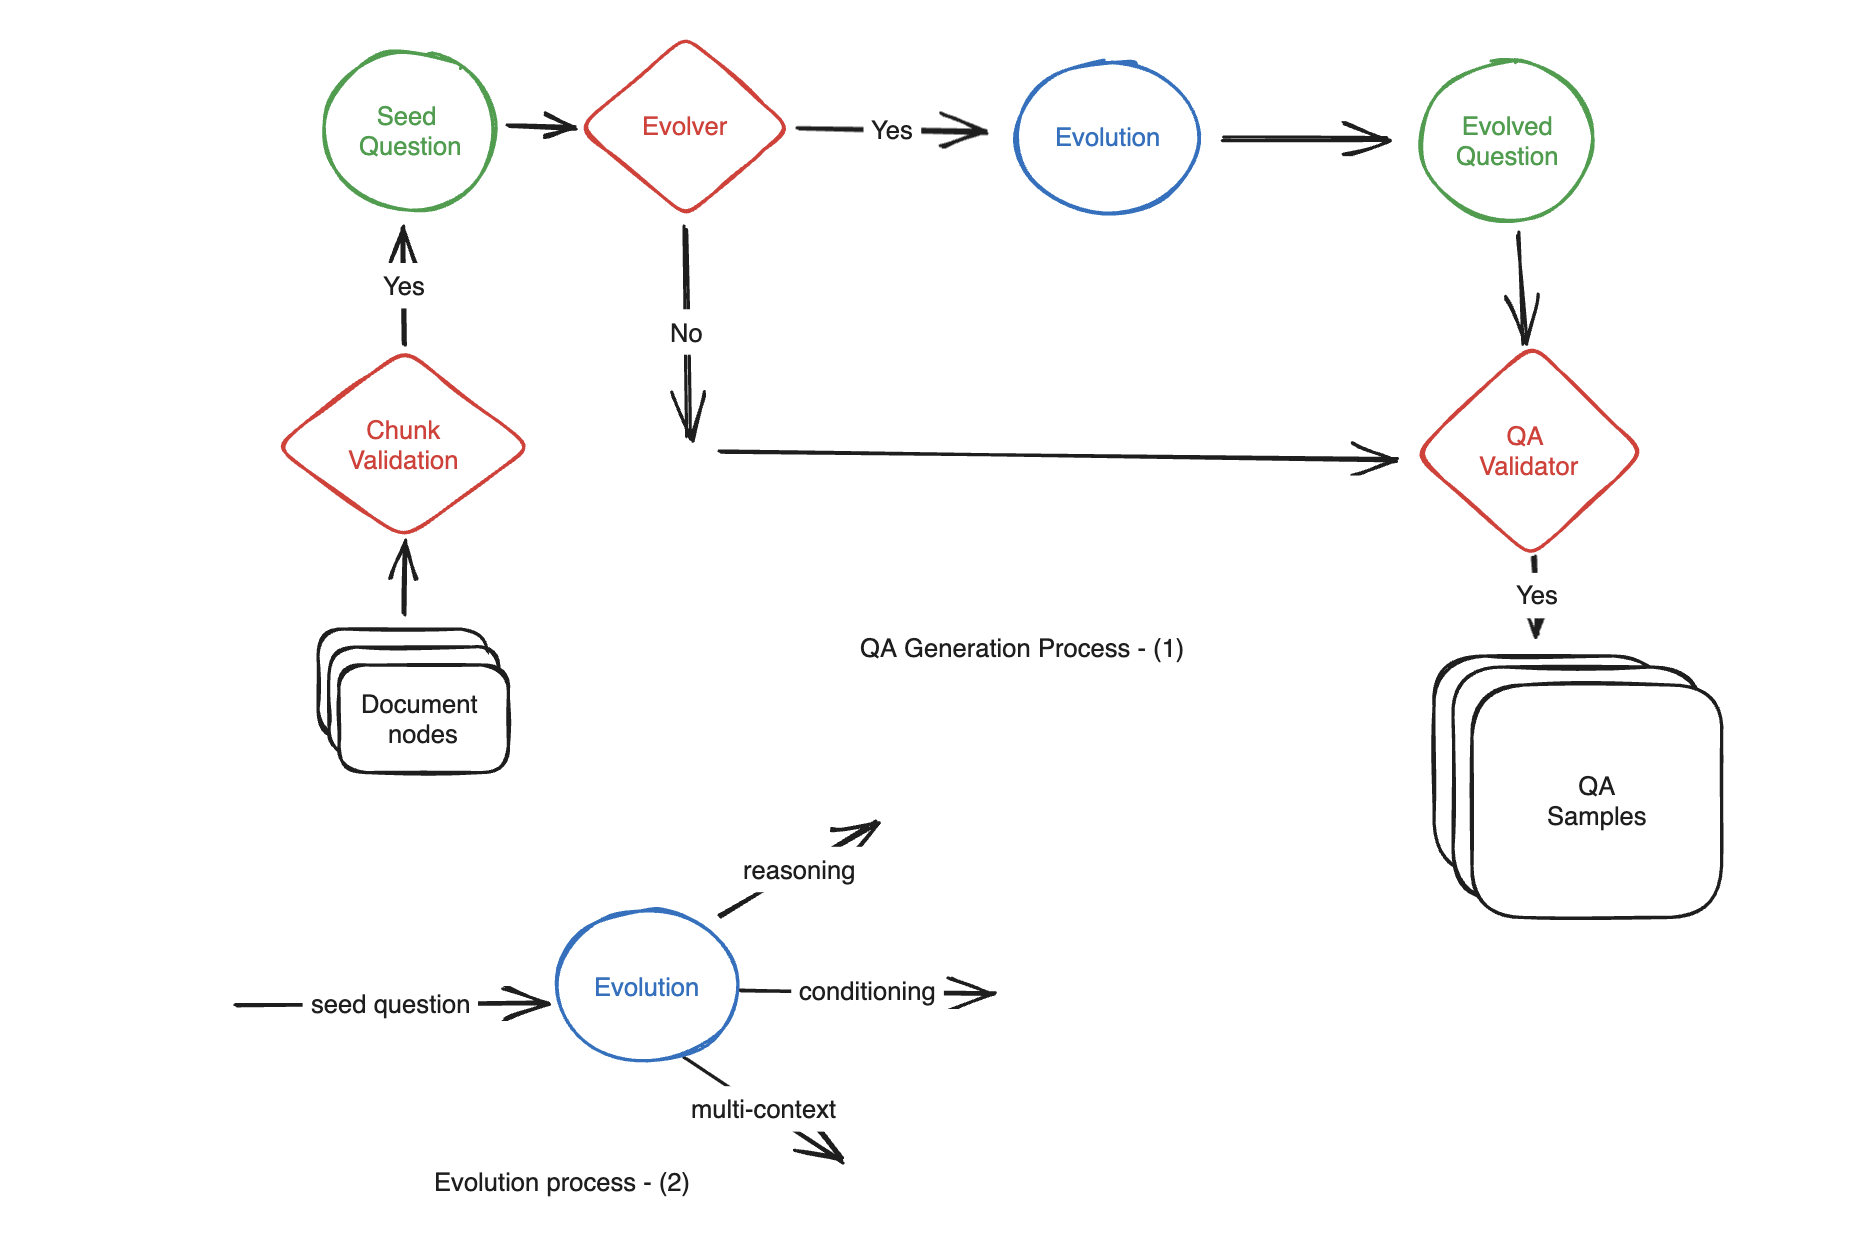


### In-Depth Evolution

Language Language Models (LLMs) possess the capability to transform simple questions into more complex ones effectively. To generate medium to hard samples from the provided documents, we employ the following methods:

- **Reasoning:** Rewrite the question in a way that enhances the need for reasoning to answer it effectively.

- **Conditioning:** Modify the question to introduce a conditional element, which adds complexity to the question.

- **Multi-Context:** Rephrase the question in a manner that necessitates information from multiple related sections or chunks to formulate an answer.

Moreover, our paradigm extends its capabilities to create conversational questions from the given documents:

- **Conversational:** A portion of the questions, following the evolution process, can be transformed into conversational samples. These questions simulate a chat-based question-and-follow-up interaction, mimicking a chat-Q&A pipeline.

Moving forward, we are will be expanding the range of evolution techniques to offer even more diverse evaluation possibilities.

### Getting Started

In [ ]:
import os
os.environ["OPENAI_API_KEY"] = "your-openai-key"

In [7]:
import json
from llama_index import download_loader
from ragas.testset import TestsetGenerator


/opt/anaconda3/envs/ragas/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Load documents using document loader

In [8]:
SemanticScholarReader = download_loader("SemanticScholarReader")
loader = SemanticScholarReader()
# narrow down the search space
query_space = "large language models"
# increase limit to get more documents
documents = loader.load_data(query=query_space, limit=10)

### Basic use-case
#### Generate test set using default configurations

In [9]:
testsetgenerator = TestsetGenerator.from_default()
test_size = 2  # Number of samples to generate
testset = testsetgenerator.generate(documents, test_size=test_size)

3it [00:36, 12.04s/it]                                                                  


In [10]:
testset.to_pandas()

,question,context,answer,question_type,episode_done
0,What is the proposed method for reducing the n...,"- We propose Low-Rank Adaptation, or LoRA, whi...",The proposed method for reducing the number of...,simple,True
1,"What is the purpose of the ""Let's think step b...",- Providing these steps for prompting demonstr...,"The purpose of the ""Let's think step by step"" ...",simple,True


### Advanced use-case

- Use custom LLMs

    - `generator_llm`: Model is used for generating seed question, evolving question and answer generation
    - `critic_llm`: Model is used for filtering and validating questions/chunks.
    - `embeddings_model`: Model used to generate embeddings during the evolution process.

In [12]:
from langchain.embeddings import OpenAIEmbeddings
from langchain.chat_models import ChatOpenAI

generator_llm = ChatOpenAI(model="gpt-3.5-turbo")
critic_llm = ChatOpenAI(model="gpt-4")
embeddings_model = OpenAIEmbeddings()

- Control data diversity
    - `test_set_distribution`: Control distribution of question types.
    - `chat_qa`: Control the percentage of Chat-QA samples.


In [15]:
testset_distribution = {
    "simple": 0.3,
    "reasoning": 0.3,
    "multi_context": 0.2,
    "conditional": 0.2,
}

chat_qa = 0.2

- Intiantiate the `TestsetGenerator`

In [16]:
test_generator = TestsetGenerator(
    generator_llm=generator_llm,
    critic_llm=critic_llm,
    embeddings_model=embeddings_model,
    testset_distribution=testset_distribution,
    chat_qa=chat_qa,
)

- Determine a desired `test_size`

In [19]:
test_size = 5

- Generate samples

In [20]:
testset = testsetgenerator.generate(documents, test_size=test_size)

15it [01:02,  4.18s/it]                                                                 


- Export to pandas and save

In [21]:
test_df = testset.to_pandas()
test_df.to_csv("test-data-ragas.csv")
test_df.head()

,question,context,answer,question_type,episode_done
0,What technique improves the performance of lar...,"- ""We explore how generating a chain of though...",The technique that improves the performance of...,simple,True
1,What phenomenon is discussed in the paper rega...,- This paper instead discusses an unpredictabl...,The phenomenon discussed in the paper is the e...,reasoning,True
2,What is the purpose of chain-of-thought (CoT) ...,- Providing these steps for prompting demonstr...,The purpose of chain-of-thought (CoT) promptin...,simple,True
3,What is the performance of the largest fine-tu...,"On the MathQA-Python dataset, the largest fine...",The performance of the largest fine-tuned mode...,simple,True
4,What is the accuracy increase of Zero-shot-CoT...,Experimental results demonstrate that our Zero...,The accuracy increase of Zero-shot-CoT on Mult...,reasoning,True
